# Preprocess ESA CCI SM

In [1]:
import xarray as xr 
from pathlib import Path
import rioxarray
import sys
import geopandas as gpd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("/home/tommy/neuralhydrology")

from scripts.clip_netcdf_to_shapefile import (
    create_camels_basin_timeseries
)

In [2]:
data_dir = Path("/datadrive/data")
shp_data_dir = data_dir / "CAMELS_GB_DATASET"
path_to_sm_data = data_dir / "esa_cci_sm_gb.nc"

# Raw data

In [3]:
sm = xr.open_dataset(path_to_sm_data).sortby("time")
sm

<xarray.Dataset>
Dimensions:  (lat: 35, lon: 37, time: 15036)
Coordinates:
  * lat      (lat) float32 58.62 58.38 58.12 57.88 ... 50.88 50.62 50.38 50.12
  * lon      (lon) float32 -7.375 -7.125 -6.875 -6.625 ... 1.125 1.375 1.625
  * time     (time) datetime64[ns] 1978-11-01 1978-11-02 ... 2019-12-31
Data variables:
    sm       (time, lat, lon) float32 ...

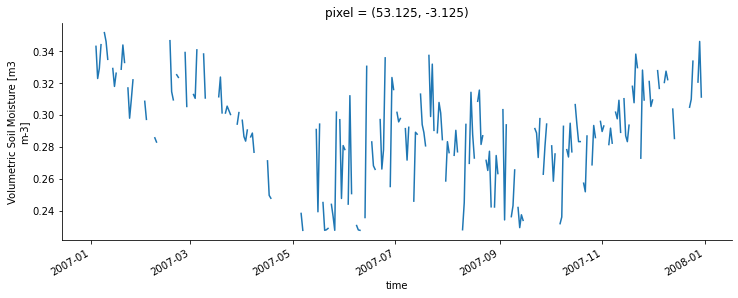

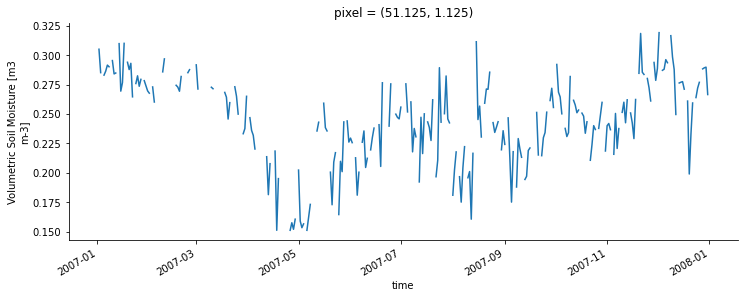

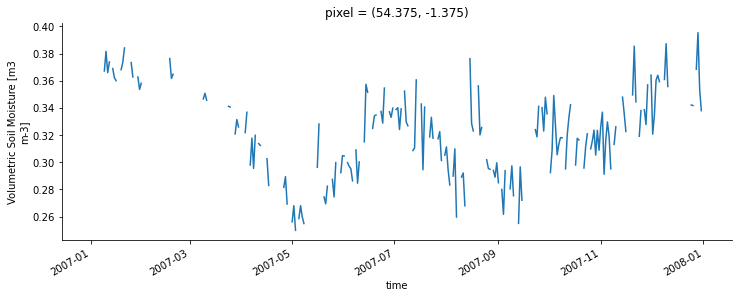

In [4]:
pixels = sm.stack(pixel=["lat", "lon"]).dropna("pixel", how="all")
choices = np.random.choice(pixels.pixel.values, 3)


for px in choices:
    f, ax = plt.subplots(figsize=(12, 4))
    pixels.sel(pixel=px)["sm"].sel(time="2007").plot(ax=ax)
    sns.despine()

# Chop out basins

In [5]:
# (data_dir / "camels_basin_ESACCI_sm.nc").unlink()
if not (data_dir / "camels_basin_ESACCI_sm.nc").exists():
    esa_ds = create_camels_basin_timeseries(path_to_sm_data=path_to_sm_data, shp_data_dir=shp_data_dir)
    
    # save the catchment averaged timeseries of soil moisture
    esa_ds.to_netcdf(data_dir / "camels_basin_ESACCI_sm.nc")
else:
    esa_ds = xr.open_dataset(data_dir / "camels_basin_ESACCI_sm.nc")
    
esa_ds["station_id"] = esa_ds.station_id.astype("int64")
esa_ds = esa_ds.sortby("time")
esa_ds

<xarray.Dataset>
Dimensions:      (station_id: 670, time: 15036)
Coordinates:
  * time         (time) datetime64[ns] 1978-11-01 1978-11-02 ... 2019-12-31
    spatial_ref  int64 ...
  * station_id   (station_id) int64 10002 10003 1001 ... 96002 96004 97002
Data variables:
    sm           (station_id, time) float32 ...

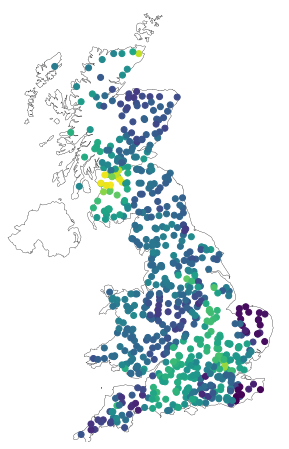

In [6]:
from scripts.geospatial import (initialise_gb_spatial_plot, load_latlon_points)

points = load_latlon_points(Path("/home/tommy/spatio_temporal/data"))
points = gpd.GeoDataFrame((esa_ds["sm"].median(dim="time").to_dataframe()).join(points)).drop(columns="spatial_ref")
ax = initialise_gb_spatial_plot()
points.plot("sm", ax=ax);

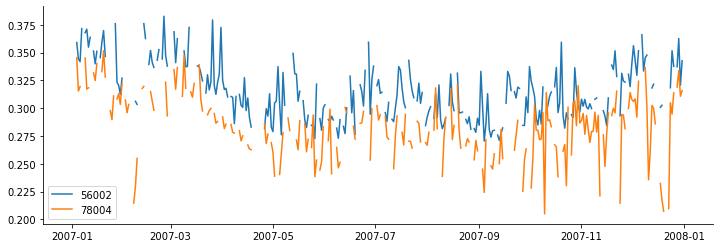

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns 


f, ax = plt.subplots(figsize=(12, 4))
for _ in range(2):
    sid = np.random.choice(esa_ds.station_id)
    sm = esa_ds.sel(station_id=sid, time="2007").drop(["spatial_ref", "station_id"])
    ax.plot(sm.time, sm.sm, label=sid)


plt.legend()
sns.despine()

# Interpolate

In [8]:
from scripts.cell_state.cell_state_dataset import fill_gaps

interp_esa_ds = fill_gaps(esa_ds, fill="interpolate")

Filling gaps with method interpolate: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it, sm]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 


f, ax = plt.subplots(figsize=(12, 4))
for _ in range(2):
    sid = np.random.choice(esa_ds.station_id)
    sm = interp_esa_ds.sel(station_id=sid, time="2007").drop(["spatial_ref", "station_id"])
    ax.plot(sm.time, sm.sm, label=sid)


plt.legend()
sns.despine()

# Calculate 7 Day rolling average

In [44]:
# rolling = interp_esa_ds.rolling(time=7).mean()
interp_esa_ds.rolling(time=7).mean()

<xarray.Dataset>
Dimensions:          (station_id: 670, time: 15036)
Coordinates:
  * time             (time) datetime64[ns] 1978-11-01 1978-11-02 ... 2019-12-31
    spatial_ref      int64 0
  * station_id       (station_id) int64 10002 10003 1001 ... 96002 96004 97002
Data variables:
    sm               (station_id, time) float32 nan nan nan ... 0.318 0.3199
    7_day_smooth_sm  (station_id, time) float32 nan nan nan ... 0.3121 0.314

In [31]:
rolling = rolling.rename({"sm": "7_day_smooth_sm"})

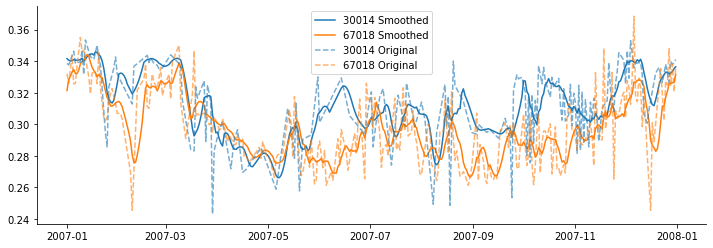

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns 


pp = np.random.choice(rolling.station_id.values, 2)

f, ax = plt.subplots(figsize=(12, 4))
for _ in range(2):
    sid = pp[_]
    sm = rolling.sel(station_id=sid, time="2007").drop(["spatial_ref", "station_id"])
    ax.plot(sm.time, sm["7_day_smooth_sm"], label=f"{sid} Smoothed", alpha=1, color=f"C{_}")

for _ in range(2):
    sid = pp[_]
    sm = interp_esa_ds.sel(station_id=sid, time="2007").drop(["spatial_ref", "station_id"])
    ax.plot(sm.time, sm.sm, alpha=0.6, ls="--", label=f"{sid} Original", color=f"C{_}")


plt.legend()
sns.despine()

# Save interpolated and smoothed

In [46]:
interp_esa_ds = interp_esa_ds.merge(rolling)
interp_esa_ds

<xarray.Dataset>
Dimensions:          (station_id: 670, time: 15036)
Coordinates:
  * time             (time) datetime64[ns] 1978-11-01 1978-11-02 ... 2019-12-31
    spatial_ref      int64 0
  * station_id       (station_id) int64 10002 10003 1001 ... 96002 96004 97002
Data variables:
    sm               (station_id, time) float32 nan nan nan ... 0.3326 0.3221
    7_day_smooth_sm  (station_id, time) float32 nan nan nan ... 0.318 0.3199

In [48]:
filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
# filepath.unlink()
interp_esa_ds.to_netcdf(filepath)

# Append to CamelsGB

In [39]:
st_dir = Path("/home/tommy/spatio_temporal")
ds = xr.open_dataset(st_dir / "data/ALL_dynamic_ds.nc")

In [40]:
# interp_esa_ds.sel(time=)
_match = interp_esa_ds.sel(time=np.isin(interp_esa_ds.time.values, ds.time.values), station_id=np.isin(interp_esa_ds.station_id.values, ds.station_id.values))
camels_extend = ds.merge(_match).drop("spatial_ref")

In [41]:
camels_extend.data_vars

Data variables:
    precipitation    (time, station_id) float64 ...
    pet              (time, station_id) float64 ...
    temperature      (time, station_id) float64 ...
    discharge_spec   (time, station_id) float64 ...
    discharge_vol    (time, station_id) float64 ...
    peti             (time, station_id) float64 ...
    humidity         (time, station_id) float64 ...
    shortwave_rad    (time, station_id) float64 ...
    longwave_rad     (time, station_id) float64 ...
    windspeed        (time, station_id) float64 ...
    sm               (station_id, time) float32 nan nan nan nan ... nan nan nan
    7_day_smooth_sm  (station_id, time) float32 nan nan nan nan ... nan nan nan

In [42]:
camels_extend.to_netcdf(data_dir / "SOIL_MOISTURE/camels_extend_cci_sm.nc")

In [43]:
camels_extend

<xarray.Dataset>
Dimensions:          (station_id: 671, time: 16436)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 102001 106001 107001
  * time             (time) datetime64[ns] 1970-10-01 1970-10-02 ... 2015-09-30
Data variables:
    precipitation    (time, station_id) float64 ...
    pet              (time, station_id) float64 ...
    temperature      (time, station_id) float64 ...
    discharge_spec   (time, station_id) float64 ...
    discharge_vol    (time, station_id) float64 ...
    peti             (time, station_id) float64 ...
    humidity         (time, station_id) float64 ...
    shortwave_rad    (time, station_id) float64 ...
    longwave_rad     (time, station_id) float64 ...
    windspeed        (time, station_id) float64 ...
    sm               (station_id, time) float32 nan nan nan nan ... nan nan nan
    7_day_smooth_sm  (station_id, time) float32 nan nan nan nan ... nan nan nan

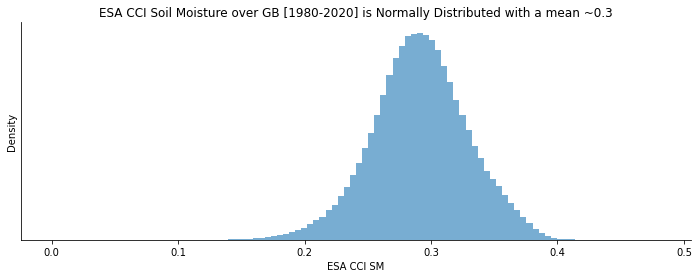

In [15]:
arr = interp_esa_ds["sm"].values

f, ax = plt.subplots(figsize=(12, 4))
ax.hist(arr[np.isfinite(arr)], bins=100, alpha=0.6);
ax.set_title("ESA CCI Soil Moisture over GB [1980-2020] is Normally Distributed with a mean ~0.3")
ax.set_xlabel("ESA CCI SM")
ax.set_ylabel("Density")
ax.set_yticks([])
ax.set_yticklabels([])
sns.despine()